In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


### 문제 파악
- 타이타닉 우주선이 시공간 변칙성과 충돌했다.
- 그 안에 타고 있던 13000명의 승객 중 절반이 사고에 의하여 다른 차원으로 이송되었다.
- 손상된 컴퓨터 시스템에서 복구된 기록을 사용해 어떤 승객이 변칙적으로 운송되었는지 예측해야 한다.
- 내 임무는 우주선 타이타닉이 이 시공간 이상과 충돌하는 동안 승객이 다른 차원으로 이송되었는지 여부를 예측하는 것이다.

### 파일 및 데이터 필드
- train.csv - 훈련 데이터로 사용되는 승객의 약 2/3(~8700)에 대한 개인 기록.
   - PassengerId- 각 승객에 대한 고유 ID. 각 ID는 승객이 함께 여행하는 그룹 gggg_pp을 gggg나타내며 pp는 그룹 내 번호. 그룹의 사람들은 보통 가족 구성원이지만 항상 그런 것은 아니다.
   - HomePlanet- 승객이 출발한 행성, 일반적으로 영구 거주 행성.
   - CryoSleep- 승객이 항해 기간 동안 정지된 애니메이션에 놓이도록 선택했는지 여부를 나타낸다. cryosleep의 승객은 객실에 국한된다.
   - Cabin- 승객이 머물고 있는 객실 번호. Deck/num/side 형식을 취하며, 여기에서 side는 Port의 경우 P 또는 Starboard의 경우 S일 수 있다.
   - Destination- 목적지
   - Age- 승객의 나이.
   - VIP- 승객이 항해 중 특별 VIP 서비스를 지불했는지 여부.
   - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 우주선 타이타닉의 다양한 고급 편의 시설에 대해 청구한 금액.
   - Name- 승객의 성과 이름.
   - Transported- 승객이 다른 차원으로 이송되었는지 여부. 이것은 예측하려는 대상인 열.
- test.csv - 테스트 데이터로 사용되는 나머지 승객의 1/3(~4300)에 대한 개인 기록. Transported당신의 임무는 이 세트에 있는 승객의 가치를 예측하는 것.
- sample_submission.csv - 올바른 형식의 제출 파일.
 - PassengerId- 테스트 세트의 각 승객에 대한 ID.
 - Transported- 목표. 각 승객에 대해 True 또는 False를 예측.

# Step1. 라이브러리 및 데이터 불러오기
- 라이브러리 버전 확인

In [2]:
from IPython.display import clear_output
#!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


#from lightgbm import LGBMClassifier
#import lazypredict
#from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("numpy version is : ", np.__version__)
print("pandas version is : ", pd.__version__)
print("seaborn version is : ", sns.__version__)

numpy version is :  1.20.3
pandas version is :  1.3.5
seaborn version is :  0.11.2


In [5]:
# Data Loading and Preparation

train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

📌 기차 데이터의 관찰:
* 기차 데이터는 총 14개의 열과 8693개의 행이 있다.
* 기차 데이터에는 2324개의 결측값이 있는 119378개의 관측값이 포함되어 있다.
* 12개의 모든 기능 열에는 결측값이 있으며 CryoSleep에서는 결측값이 가장 높음(217)
* Transported는 기차 데이터 세트에서만 사용할 수 있는 대상 변수이다.

In [6]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}]')
print(f'\033[94mNumber of colunmns in train data: {train.shape[1]}]')
print(f'\033[94mNumber of values in train data: {train.count().sum()}]')
print(f'\033[94mNumber of missing values in train data: {sum(train.isna().sum())}]')
# 이 메서드는 데이터프레임 내에 결측 값을 확인하여, 그 결과를 True 또는 False로 반환

Number of rows in train data: 8693]
Number of colunmns in train data: 14]
Number of values in train data: 119378]
Number of missing values in train data: 2324]


- 열별 결측값

In [8]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


- 다음은 개수, 평균, 표준편차, 최소값, 1사분위수, 중앙값, 3사분위수 및 최대값에 대한 정보를 포함하는 각 변수에 대한 기본 통계이다.

In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


📌 테스트 데이터의 관찰:
* 테스트 데이터는 총 13열 4277행입니다.
* 기차 데이터에는 1117개의 결측값이 있는 54484개의 관측값이 포함되어 있습니다.
* 12개의 모든 기능 열에는 결측값이 있으며 FoodCourt는 결측값이 가장 높음(106)

In [10]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [11]:
print(f'\033[94mNumber of row in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNumber of row with missing values in tset data: {sum(test.isna().sum())}')

Number of row in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
Number of row with missing values in tset data: 1117


- 열별 결측값

In [12]:
print(f'\033[94')
print((test.isna().sum().sort_values(ascending = False)))

[94
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


- 다음은 개수, 평균, 표준편차, 최소값, 1사분위수, 중앙값, 3사분위수 및 최대값에 대한 정보를 포함하는 각 변수에 대한 기본 통계이다.

In [13]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


- submission File

In [14]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# Step2. 탐색적 자료 분석 (EDA)
- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석해서 설명을 달아야 함
- 약간의 데이터 전처리

- 데이터 개요

In [15]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [16]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


📌 널값 분포에 대한 관찰:
* 행의 결측값의 최대값은 3이고 최소값은 결측값이 없음
* 흥미롭게도 결측값 분포(행 기준)는 훈련 데이터 세트와 테스트 데이터 세트 간에 상당히 동일.
* 결측값이 없는 관측값(행 기준)이 약 76% 있다.
* 1~3개의 결측값이 있는 관측치(행 기준)의 나머지 24%

- 열별 Null 값 분포

- 행별 Null 값 분포

In [17]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

In [18]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

# Step3. 데이터 전처리
- Feature Engineering 이라고도 한다
- ML 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수 (도출 변수) 만들기
    + 왜 이 변수를 만들었는지에 대한 본인의 설명 필요

### 결측값 처리 (참조)
- 결측 값을 처리하는 방법에 대한 몇 가지 참조:
    - Alexis Cook의 결측값
    - 데이터 정리 과제: Rachael Tatman의 결측값 처리
    - Parul Pandey의 Python에서 누락된 값 처리 가이드

- 기본적으로 결측값을 처리하는 기능이 있는 일부 모델은 다음과 같다.
    - XGBoost: https://xgboost.readthedocs.io/en/latest/faq.html
    - LightGBM: https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
    - Catboost: https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html

### 연속성과 범주형 데이터 분포
📌 널값 분포에서 관찰:
* 12개의 기능 중 6개의 기능은 연속형, 2개의 기능은 텍스트 데이터, 4개의 기능은 범주형입니다.
* HomePlanet과 Destination은 3가지 고유한 값을 가집니다.
* CryoSleep 및 VIP는 bool 기능입니다.

In [19]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


### 연속적인 특성의 특성 분포
- 나이 분포

- 범주형 특성의 특성 분포

In [20]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

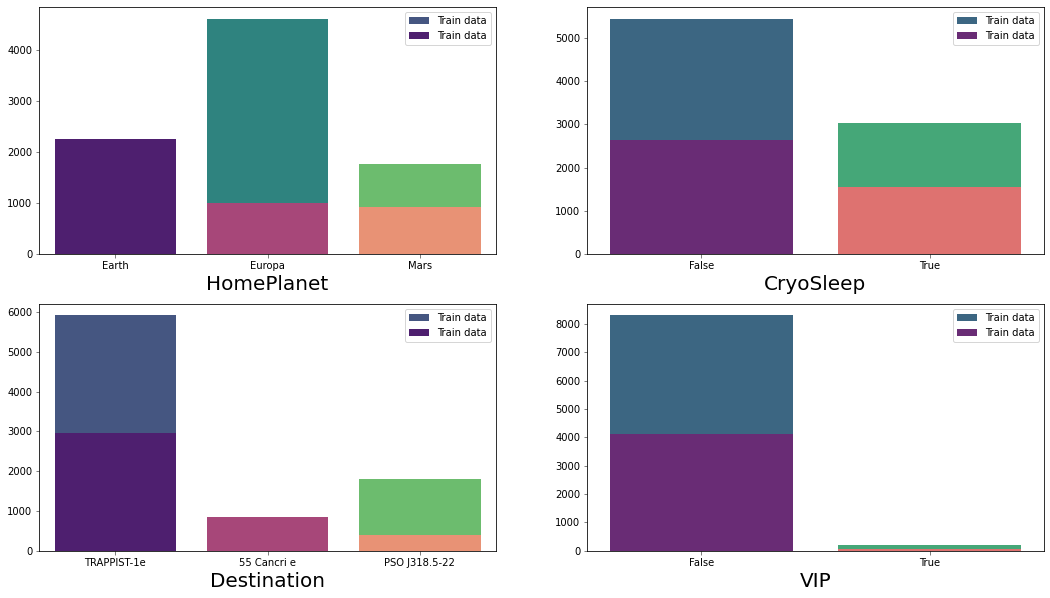

In [21]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Train data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

# Step4. 머신러닝 모형 개발
- 모형에 대한 설명
- 모형을 1-2개 사용
- 교차 검증
- 하이퍼파라미터 튜닝

### Target 분포
📌 널값 분포에서 관찰:
* 목표값은 0과 1이 있습니다.
* 두 목표값은 거의 균등하게 분포되어 있습니다.

In [22]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


### Correlation matrix 상관 행렬

In [23]:
fig = px.imshow(train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

### 데이터 전처리
- 결측값 대입
- 범주형 특성 인코딩

In [24]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

In [25]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

# Step5. 
- 훈련데이터 쪼갠다. 훈련데이터 + 검증데이터로 분리
- 정확도 비교
- 혼동행렬(Confusion Matriax) 설명 -> 스스로 찾아보고 설명을 넣는다

In [26]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

### 모델링
- LGBM Classifier(5FOLDS):

In [27]:
from lightgbm import LGBMClassifier

lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.81%, Run Time: 0.13s

========== Fold=2 ==========
Fold=2, Accuracy score: 0.78%, Run Time: 0.09s

========== Fold=3 ==========
Fold=3, Accuracy score: 0.79%, Run Time: 0.09s

========== Fold=4 ==========
Fold=4, Accuracy score: 0.79%, Run Time: 0.08s

========== Fold=5 ==========
Fold=5, Accuracy score: 0.81%, Run Time: 0.09s

Mean Accuracy : 0.7958136330880743


- 특성 중요도

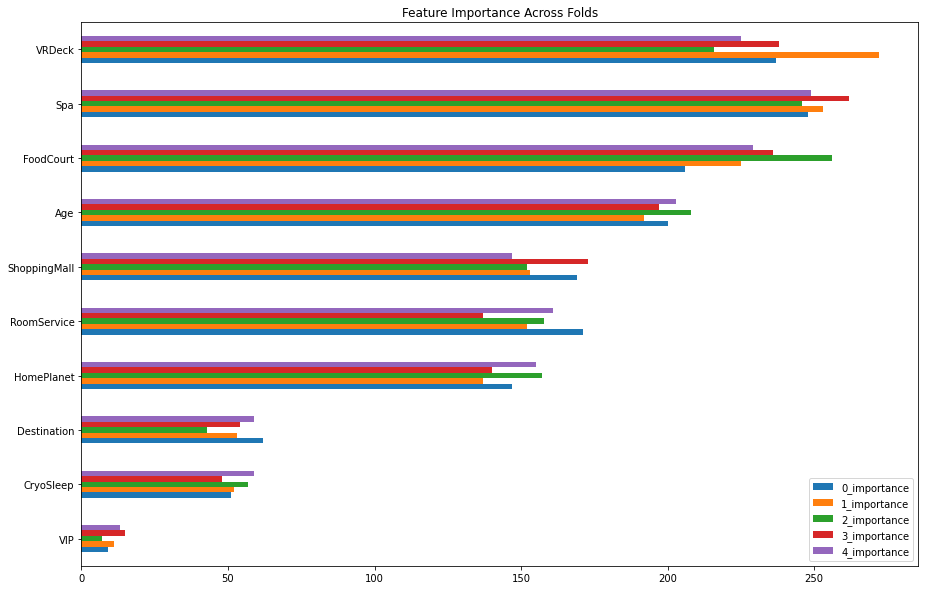

In [28]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

- LGBM Classifier Submission

In [29]:
submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


### confution Matrix (혼동행렬)
실제 데이터와 데이터 분석 모델의 예측결과를 행렬의 형태로 나타낸 것이다.
- 분석 모델의 예측 결과 1이면 Positive, 0이면 Negative.
    - 예측 결과와 실제 데이터가 일치하면 True, 일치하지 않으면 False.
    - 예측 결과가 1인데 실제 데이터도 1이면 True Positive (TP)
    - 예측 결과가 1인데 실제 데이터가 0이면 False Positive (FP)
    - 예측 결과가 0인데 실제 데이터가 1이면 False Negative (FN)
    - 예측 결과가 0인데 실제 데이터도 0이념 True Negative (TN)
    

혼동행렬에서 바로 계산할 수 있는 5가지 매트릭스가 있다.
- Precision (정밀도)
    - 예측 값이 1인 결과 중 실제 데이터도 1인 경우의 비율 : TP/(TP+FP)
- Recall (재현율)
     - 실제 값이 1인 데이터 중 모델 예측도 1인 비율 : TP/(TP+FN)
     - = Sensitivity(민감도) = TRP(True Positive Rate) = Hit Rate
- Specificity
    - 실제 값이 0인 데이터 중 예측 값이 0인 비율 : TN/(FP+TN)
    - = TNR (True Negative Rate)
- False Positive Rate (FPR, 거짓긍정률)
    - 실제 값이 0인 데이터 중 예측 값이 1인 비율 : FP/(FP+TN)
- Accuracy(정확도)
    - 분석 모델이 제대로 예측한 비율 : (TP+TN)/(TP+FP+FN+TN)

다음 두 가지는 기본 메트릭스를 활용하여 계산할 수 있다.
- F1 Score (F-Measure)
    - 정밀도와 재현율의 조화 평균 : 2TP/(2TP+FP+FN)
    - 모델의 예측 성능을 수치화한 것. 범위는 0~1
    - 정밀도나 재현율 중 하나만 높은 경우보다 둘 모두 큰 경우 F1 점수는 1에 가까워 진다 = 예측 성능이 좋아진다.
- Kappa Value (Kappa Statistics, 카피값)
    - k = (P(a)-P(e))/(1-P(e))
    - P(a) = accuracy
    - P(e) = ((TP+FP)x(FP+FN)x(FN+TN)X(FP+TN))/(TP+FP+FN+TN)^2
    - 예측 값과 실제 데이터가 '우연히'일치할 확률을 제외한 뒤 매기는 점수. 값의 범위는 0~1. 1에 가까울수록 예측값과 실제값이 일치한다. 

# Step6. 제출
- 제출 양식은 샘플 만들어지는거 보고 참고

# Reference
- 다른 사람의 code 설명을 따라친다면 해야 함.
- 노트북 표절 방지 위해, 본인이 참조한 코드는 반드시 링크 걸어둘 것.
- [저자 이름, 글 제목, 링크 주소]
- SANSKAR HASIJA, 🚀Spaceship Titanic -📊EDA + 27 different models📈, https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models



# 마감일
- 4월 12일 17시 40분
- 제출 형태
    + Leaderbord 랭킹 사진 캡처
    + 고용노동부 보고 양식(다음주에 확인해서 공지예정)